# Bereinigung des Gerichtsurteils-Presseerklärungs-Datensatzes

Dieses Notebook implementiert verschiedene Ansätze zur Bereinigung des Datensatzes mit Gerichtsurteilen und zugehörigen Pressemitteilungen. Das Ziel ist die Identifikation und Entfernung von Pressemitteilungen, die keinen direkten Bezug zu einem ergangenen Urteil haben (z.B. Ankündigungen zukünftiger Verhandlungen oder allgemeine Mitteilungen).


## Überblick

Wir implementieren und evaluieren folgende Ansätze:

1. **Regelbasierte Filter**: 
   - Keywords und Muster zur Erkennung von Ankündigungen
   - Regex-Patterns für typische Formulierungen
   - Strukturelle Merkmale der Texte

2. **Semantische Ähnlichkeit**:
   - Berechnung von Text-Embeddings
   - Kosinus-Ähnlichkeit zwischen Urteil und Pressemitteilung
   - Identifikation inhaltlich abweichender Mitteilungen

3. **Überwachtes Machine Learning**:
   - Trainieren eines Klassifikators auf Basis der vorherigen Methoden
   - Logistische Regression mit TF-IDF Features
   - Analyse der wichtigsten Merkmale

4. **Unüberwachtes Clustering**:
   - Gruppierung ähnlicher Pressemitteilungen
   - Topic Modeling zur Mustererkennung
   - Identifikation von Ankündigungs-Clustern

Am Ende vergleichen wir die Methoden und kombinieren sie zu einem robusten Gesamtansatz.

## Erweiterte Bereinigungsansätze

In diesem Abschnitt implementieren wir weitere Ansätze zur Bereinigung des Datensatzes, die in `ansatz_bereinigung.md` beschrieben wurden:

1. Erweiterter regelbasierter Ansatz
2. Semantische Ähnlichkeit mit Embeddings
3. Überwachtes Machine Learning (Klassifikation)
4. Unüberwachte Verfahren (Clustering/Topic Modeling)



## 1. Vorbereitung für erweiterte Bereinigungsansätze

In [3]:
import re
import spacy
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# GPU-Beschleunigung importieren
try:
    import cudf
    import cuml
    import cupy as cp
    from cuml.feature_extraction.text import TfidfVectorizer as cuTfidfVectorizer
    from cuml.decomposition import PCA as cuPCA
    from cuml.cluster import KMeans as cuKMeans
    from cuml.linear_model import LogisticRegression as cuLogisticRegression
    from cuml.metrics import pairwise_distances
    from cuml.preprocessing import normalize
    USE_GPU = True
    print("GPU-Beschleunigung ist aktiviert (RAPIDS-Bibliotheken geladen)")
except ImportError:
    USE_GPU = False
    print("GPU-Beschleunigung ist nicht verfügbar, verwende CPU-Version")

# Für alle Methoden laden wir die Daten neu
try:
    df = pd.read_csv('data/german_courts.csv')
    print(f"Daten geladen: {len(df)} Einträge")
except Exception as e:
    print(f"Fehler beim Laden der Daten: {e}")
    # Fallback auf den bereits geladenen DataFrame, falls vorhanden

# Sprachdaten vorbereiten
try:
    nlp = spacy.load("de_core_news_sm")
    print("SpaCy deutsches Modell geladen")
except:
    print("SpaCy deutsches Modell wird installiert...")
    import subprocess
    subprocess.run(["python", "-m", "spacy", "download", "de_core_news_sm"])
    nlp = spacy.load("de_core_news_sm")
    print("SpaCy deutsches Modell geladen")

# Kleine Hilfsfunktion zum Preprocessen von Text
def preprocess_text(text):
    if pd.isna(text):
        return ""
    doc = nlp(text)
    # Nur Substantive, Verben, Adjektive und Adverbien behalten
    tokens = [token.lemma_.lower() for token in doc 
              if not token.is_stop and not token.is_punct 
              and token.is_alpha and len(token.text) > 2 
              and token.pos_ in ['NOUN', 'VERB', 'ADJ', 'ADV']]
    return " ".join(tokens)

# Sample für schnelleres Testen erstellen (optional)
sample_size = 1000  # Anzahl der zufällig ausgewählten Datensätze
sample_df = df.sample(min(sample_size, len(df)), random_state=42)

GPU-Beschleunigung ist nicht verfügbar, verwende CPU-Version
Daten geladen: 6592 Einträge
SpaCy deutsches Modell geladen


## 2. Regelbasierte Filter

Der erste Bereinigungsansatz basiert auf expliziten Regeln, die typische Muster in Ankündigungen und irrelevanten Pressemitteilungen erkennen:

- **Keywords**: Typische Wörter für Ankündigungen (z.B. "Terminankündigung", "wird verhandelt")
- **Zeitliche Marker**: Formulierungen, die auf zukünftige Ereignisse hinweisen
- **Dokumentstruktur**: Analyse von Überschriften und Textanfängen
- **Kombinierte Regeln**: Gewichtung verschiedener Indikatoren

Die Funktion `is_announcement_rule_based()` implementiert diese Logik und klassifiziert jeden Eintrag als Ankündigung oder relevante Pressemitteilung.

Regelbasierte Erkennung: 1625 von 6592 Einträgen (24.65%) sind vermutlich Ankündigungen.

Beispiele für erkannte Ankündigungen:
ID: bfh_009-17
Datum: 08. Februar 2017
Pressemitteilung (Anfang): Kostümparty eines gemeinnützigen Karnevalsvereins kein Zweckbetrieb
                
                  08. Februar 2017
                
                -
                  Nummer
                  00...
--------------------------------------------------------------------------------
ID: bfh_011-13
Datum: 20. Februar 2013
Pressemitteilung (Anfang): Kosten einer Betriebsveranstaltung sind erst bei Überschreiten einer Freigrenze Arbeitslohn. Die Freigrenze beträgt auch 2007 noch 110 €.
                
                  20. Februar 2013
          ...
--------------------------------------------------------------------------------
ID: bfh_032-17
Datum: 17. Mai 2017
Pressemitteilung (Anfang): Gewerbesteuerliche Hinzurechnung von Mieten für Konzertsäle
                
                  17. Mai 2017


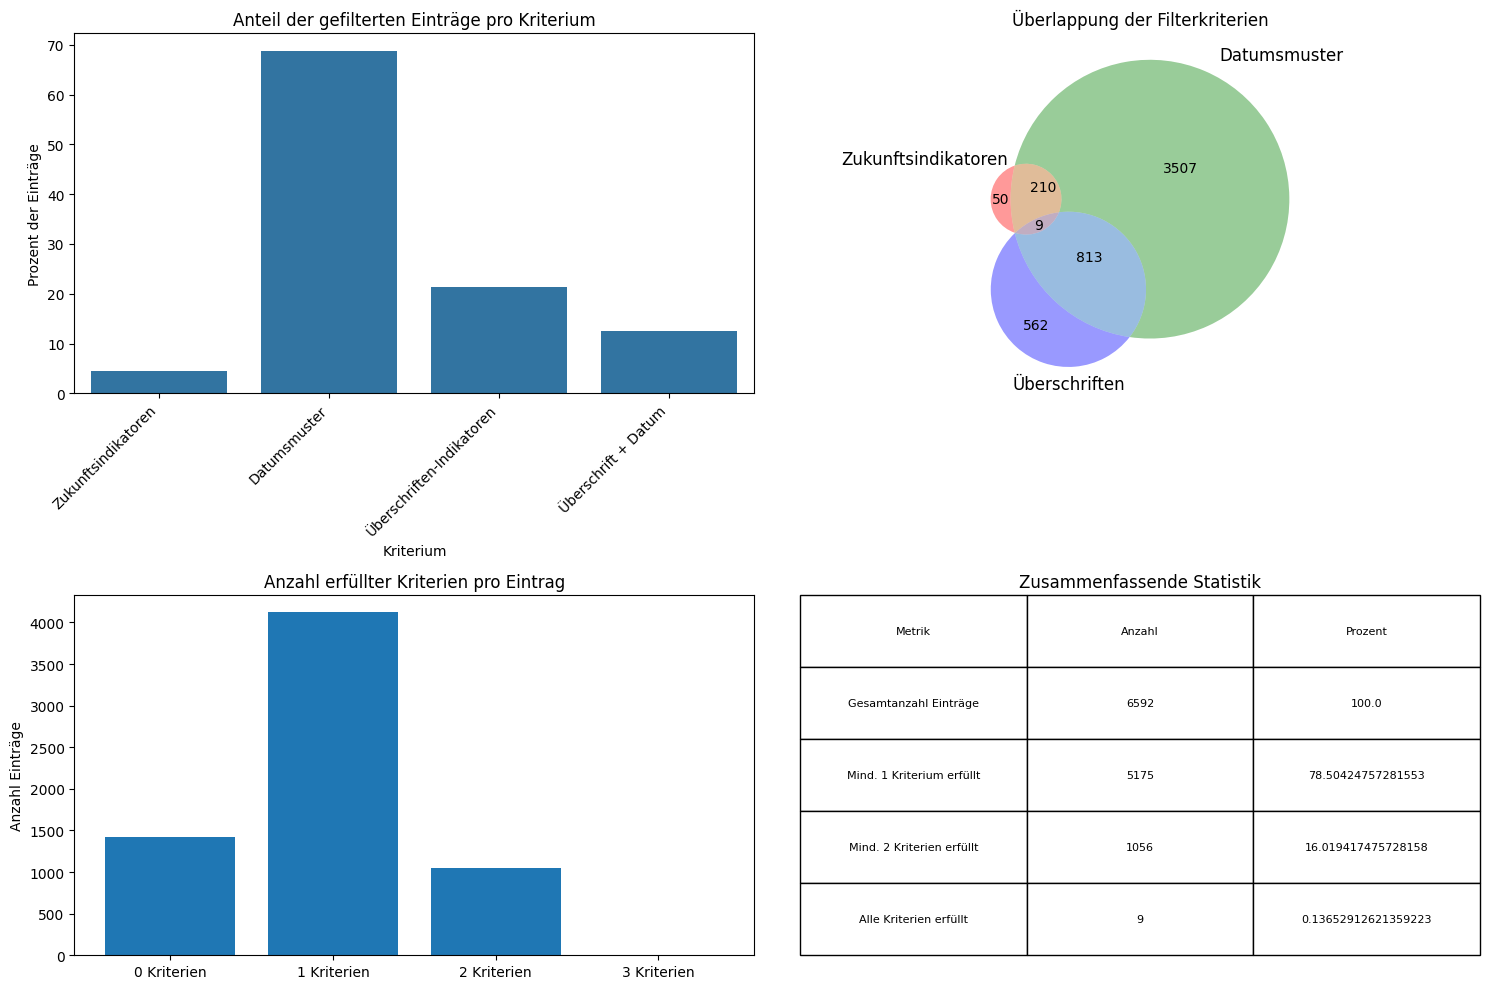


Beispiele für verschiedene Filterkombinationen:

Beispiele für Einträge, die ALLE Kriterien erfüllen:

ID: bverwg_2001-13
Text (Anfang): Pressemitteilung Nr. 13/2001  vom 28.03.2001


 EN


Keine Zulassung von Oddset-Wetten durch private Veranstalter in Bayern
 Das Bundesverwaltungsgericht hat entschieden, dass die  Veranstaltung von O...
--------------------------------------------------------------------------------

ID: bverwg_2001-22
Text (Anfang): Pressemitteilung Nr. 22/2001  vom 10.07.2001


 EN


Einreiseverbot für Ehepaar Mun
 Das Bundesverwaltungsgericht hat heute entschieden, dass die  Klage der zur sog. Mun-Bewegung zählenden deutschen  ...
--------------------------------------------------------------------------------

Beispiele für Einträge, die NUR das Kriterium 'future_indicators' erfüllen:
ID: bag_18-20
Text (Anfang): 25.06.2020
18/20 - Benachteiligung eines schwerbehinderten Bewerbers - Einladung zu einem Vorstellungsgespräch - interne Stellenausschreibung



Geht d

In [4]:
# Wir erweitern den bereits vorhandenen regelbasierten Ansatz mit detaillierteren Regex-Mustern 
# und umfangreicheren Wortlisten, um Ankündigungen und allgemeine Mitteilungen zu identifizieren

def is_announcement_rule_based(row):
    """Erkennt Ankündigungen und nicht urteilsbezogene Mitteilungen anhand von Keywords und Mustern"""
    if pd.isna(row['summary']):
        return False
    
    summary = str(row['summary']).lower()
    
    # 1. Keywords, die auf Ankündigungen hindeuten
    future_indicators = [
        'ankündigung', 'terminankündigung', 'terminhinweis', 'hinweis auf termin',
        'wird verhandelt', 'wird verhandeln', 'wird.*stattfinden', 'findet statt',
        'einladung', 'pressetermin', 'pressekonferenz', 'veranstaltung',
        'wochenvorschau', 'jahrespressekonferenz', 'pressegespräch', 'rundgang',
        'beginnt am', 'laden ein', 'lädt ein', 'sitzung vom'
    ]
    
    # 2. Regex-Muster für Datumsangaben in der Zukunft (relativ zum Erstelldatum)
    date_patterns = [
        r'am\s+\d{1,2}\.\s*\d{1,2}\.\s*\d{4}',  # "am 15.05.2023"
        r'vom\s+\d{1,2}\.\s*\d{1,2}\.',         # "vom 15.05."
        r'terminiert auf den \d{1,2}',           # "terminiert auf den 15"
        r'in der kommenden woche',               # zukünftige Verweise
        r'in der nächsten woche',
        r'demnächst'
    ]
    
    # 3. Überschriften/Anfänge, die auf Ankündigungen hindeuten
    headline_indicators = [
        'pressemitteilung nr', 'presseinformation', 'information für die presse',
        'medieninformation', 'zur information', 'mündliche verhandlung',
        'terminvorschau', 'jahresbericht', 'geschäftsbericht', 'tätigkeitsbericht',
        'stellenausschreibung', 'personelle veränderungen', 'neuer präsident'
    ]
    
    # 4. Prüfen auf Keywords am Anfang des Textes (größeres Gewicht)
    summary_start = summary[:100]
    headline_match = any(indicator in summary_start for indicator in headline_indicators)
    
    # 5. Prüfen auf allgemeine Ankündigungskeywords im gesamten Text
    keyword_match = any(re.search(r'\b' + re.escape(indicator) + r'\b', summary, re.IGNORECASE) 
                      for indicator in future_indicators)
    
    # 6. Prüfen auf Datumsmuster
    date_match = any(re.search(pattern, summary, re.IGNORECASE) for pattern in date_patterns)
    
    # Kombinierte Entscheidung mit unterschiedlicher Gewichtung
    if headline_match:
        return True  # Überschriften/Anfänge sind starke Indikatoren
    elif keyword_match and date_match:
        return True  # Kombination aus Keyword und Datumsmuster
    elif keyword_match and ('mündliche verhandlung' in summary or 'termin' in summary):
        return True  # Spezifische Kombinationen
    
    return False  # Default: keine Ankündigung

# Anwenden der regelbasierten Methode auf den Datensatz
df['is_announcement_rule'] = df.apply(is_announcement_rule_based, axis=1)

# Auswertung der regelbasierten Methode
announcement_count = df['is_announcement_rule'].sum()
print(f"Regelbasierte Erkennung: {announcement_count} von {len(df)} Einträgen ({announcement_count/len(df)*100:.2f}%) sind vermutlich Ankündigungen.")

# Beispiele für erkannte Ankündigungen anzeigen
print("\nBeispiele für erkannte Ankündigungen:")
announcement_examples = df[df['is_announcement_rule']].head(3)
for _, row in announcement_examples.iterrows():
    print(f"ID: {row['id']}")
    print(f"Datum: {row['date']}")
    print(f"Pressemitteilung (Anfang): {row['summary'][:200]}...")
    print("-" * 80)

### 1. Erweiterter regelbasierter Ansatz (Keywords und Muster)

def analyze_rule_based_filters(text):
    """Analysiert einen Text mit verschiedenen regelbasierten Filtern und gibt deren einzelne Ergebnisse zurück"""
    if pd.isna(text):
        return {
            'future_indicators': False,
            'date_patterns': False,
            'headline_indicators': False,
            'headline_date': False
        }
    
    text = str(text).lower()
    results = {}
    
    # 1. Keywords, die auf Ankündigungen hindeuten
    future_indicators = [
        'ankündigung', 'terminankündigung', 'terminhinweis', 'hinweis auf termin',
        'wird verhandelt', 'wird verhandeln', 'wird.*stattfinden', 'findet statt',
        'einladung', 'pressetermin', 'pressekonferenz', 'veranstaltung',
        'wochenvorschau', 'jahrespressekonferenz', 'pressegespräch', 'rundgang',
        'beginnt am', 'laden ein', 'lädt ein', 'sitzung vom'
    ]
    results['future_indicators'] = any(re.search(r'\b' + re.escape(indicator) + r'\b', text, re.IGNORECASE) 
                                     for indicator in future_indicators)
    
    # 2. Datumsmuster
    date_patterns = [
        r'am\s+\d{1,2}\.\s*\d{1,2}\.\s*\d{4}',  # "am 15.05.2023"
        r'vom\s+\d{1,2}\.\s*\d{1,2}\.',         # "vom 15.05."
        r'terminiert auf den \d{1,2}',           # "terminiert auf den 15"
        r'in der kommenden woche',               # zukünftige Verweise
        r'in der nächsten woche',
        r'demnächst'
    ]
    results['date_patterns'] = any(re.search(pattern, text, re.IGNORECASE) for pattern in date_patterns)
    
    # 3. Überschriften/Anfänge, die auf Ankündigungen hindeuten
    headline_indicators = [
        'pressemitteilung nr', 'presseinformation', 'information für die presse',
        'medieninformation', 'zur information', 'mündliche verhandlung',
        'terminvorschau', 'jahresbericht', 'geschäftsbericht', 'tätigkeitsbericht',
        'stellenausschreibung', 'personelle veränderungen', 'neuer präsident'
    ]
    
    # Prüfe speziell den Textanfang (erste 100 Zeichen)
    text_start = text[:100]
    results['headline_indicators'] = any(indicator in text_start for indicator in headline_indicators)
    
    # 4. Kombination aus Überschrift und Datum
    results['headline_date'] = results['headline_indicators'] and results['date_patterns']
    
    return results

# Wende die Analyse auf den Datensatz an
print("Analysiere einzelne Filterkriterien...")
filter_results = df['summary'].apply(analyze_rule_based_filters)

# Extrahiere die Ergebnisse in separate Spalten
for criterion in ['future_indicators', 'date_patterns', 'headline_indicators', 'headline_date']:
    df[f'filter_{criterion}'] = filter_results.apply(lambda x: x[criterion])

# Erstelle Visualisierungen
plt.figure(figsize=(15, 10))

# 1. Barplot für einzelne Kriterien
criterion_counts = pd.DataFrame({
    'Kriterium': [
        'Zukunftsindikatoren',
        'Datumsmuster',
        'Überschriften-Indikatoren',
        'Überschrift + Datum'
    ],
    'Anzahl': [
        df['filter_future_indicators'].sum(),
        df['filter_date_patterns'].sum(),
        df['filter_headline_indicators'].sum(),
        df['filter_headline_date'].sum()
    ]
})

criterion_counts['Prozent'] = criterion_counts['Anzahl'] / len(df) * 100

plt.subplot(2, 2, 1)
sns.barplot(data=criterion_counts, x='Kriterium', y='Prozent')
plt.xticks(rotation=45, ha='right')
plt.title('Anteil der gefilterten Einträge pro Kriterium')
plt.ylabel('Prozent der Einträge')

# 2. Venn-Diagramm für Überlappungen
plt.subplot(2, 2, 2)
from matplotlib_venn import venn3

# Erstelle Sets für die drei Hauptkriterien
future_set = set(df[df['filter_future_indicators']].index)
date_set = set(df[df['filter_date_patterns']].index)
headline_set = set(df[df['filter_headline_indicators']].index)

venn3([future_set, date_set, headline_set], 
      ('Zukunftsindikatoren', 'Datumsmuster', 'Überschriften'))
plt.title('Überlappung der Filterkriterien')

# 3. Gestapeltes Balkendiagramm für kombinierte Effekte
plt.subplot(2, 2, 3)
filter_combinations = df[[
    'filter_future_indicators',
    'filter_date_patterns',
    'filter_headline_indicators'
]].sum(axis=1)
combination_counts = filter_combinations.value_counts().sort_index()
plt.bar(range(len(combination_counts)), combination_counts)
plt.xticks(range(len(combination_counts)), 
          [f"{i} Kriterien" for i in combination_counts.index])
plt.title('Anzahl erfüllter Kriterien pro Eintrag')
plt.ylabel('Anzahl Einträge')

# 4. Zusammenfassende Statistik
plt.subplot(2, 2, 4)
summary_stats = pd.DataFrame({
    'Metrik': [
        'Gesamtanzahl Einträge',
        'Mind. 1 Kriterium erfüllt',
        'Mind. 2 Kriterien erfüllt',
        'Alle Kriterien erfüllt'
    ],
    'Anzahl': [
        len(df),
        (filter_combinations >= 1).sum(),

        (filter_combinations >= 2).sum(),
        (filter_combinations == 3).sum()
    ]
})
summary_stats['Prozent'] = summary_stats['Anzahl'] / len(df) * 100

plt.axis('off')
plt.table(cellText=summary_stats.values,
         colLabels=summary_stats.columns,
         cellLoc='center',
         loc='center',
         bbox=[0, 0, 1, 1])
plt.title('Zusammenfassende Statistik')

plt.tight_layout()
plt.show()

# Zeige einige Beispiele für verschiedene Kombinationen
print("\nBeispiele für verschiedene Filterkombinationen:")

# Beispiele für Einträge, die alle Kriterien erfüllen
print("\nBeispiele für Einträge, die ALLE Kriterien erfüllen:")
all_criteria = df[df['filter_future_indicators'] & 
                 df['filter_date_patterns'] & 
                 df['filter_headline_indicators']].head(2)
for _, row in all_criteria.iterrows():
    print(f"\nID: {row['id']}")
    print(f"Text (Anfang): {row['summary'][:200]}...")
    print("-" * 80)

# Beispiele für Einträge, die nur ein bestimmtes Kriterium erfüllen
for criterion in ['future_indicators', 'date_patterns', 'headline_indicators']:
    mask = df[f'filter_{criterion}'] & ~df[[f'filter_{c}' for c in ['future_indicators', 'date_patterns', 'headline_indicators'] if c != criterion]].any(axis=1)
    examples = df[mask].head(1)
    
    print(f"\nBeispiele für Einträge, die NUR das Kriterium '{criterion}' erfüllen:")
    for _, row in examples.iterrows():
        print(f"ID: {row['id']}")
        print(f"Text (Anfang): {row['summary'][:200]}...")
        print("-" * 80)

# Speichere die Analyseergebnisse
detailed_results = df[[
    'id', 'summary', 
    'filter_future_indicators', 'filter_date_patterns', 
    'filter_headline_indicators', 'filter_headline_date'
]]
detailed_results.to_csv('data/rule_based_filter_analysis.csv', index=False)
print("\nDetailierte Analyseergebnisse wurden in 'data/rule_based_filter_analysis.csv' gespeichert.")

## 3. Semantische Ähnlichkeit

Der zweite Ansatz nutzt TF-IDF Vektorisierung und Kosinus-Ähnlichkeit, um inhaltliche Unterschiede zwischen Urteilen und Pressemitteilungen zu erkennen:

- **Vorverarbeitung**: Lemmatisierung und Filterung mit spaCy
- **TF-IDF**: Berechnung von Dokumentvektoren
- **Ähnlichkeitsmetrik**: Kosinus-Ähnlichkeit zwischen Urteil und Pressemitteilung
- **Schwellenwert**: Identifikation von Paaren mit geringer Ähnlichkeit

Dieser Ansatz ist besonders effektiv bei der Erkennung von Pressemitteilungen, die inhaltlich stark vom zugehörigen Urteil abweichen.


## Semantische Ähnlichkeit mit TF-IDF Embeddings
Berechne TF-IDF Vektoren...
Führe Text-Preprocessing durch...
Vokabulargröße: 10000
Berechne Kosinus-Ähnlichkeiten...


  0%|          | 0/6592 [00:00<?, ?it/s]

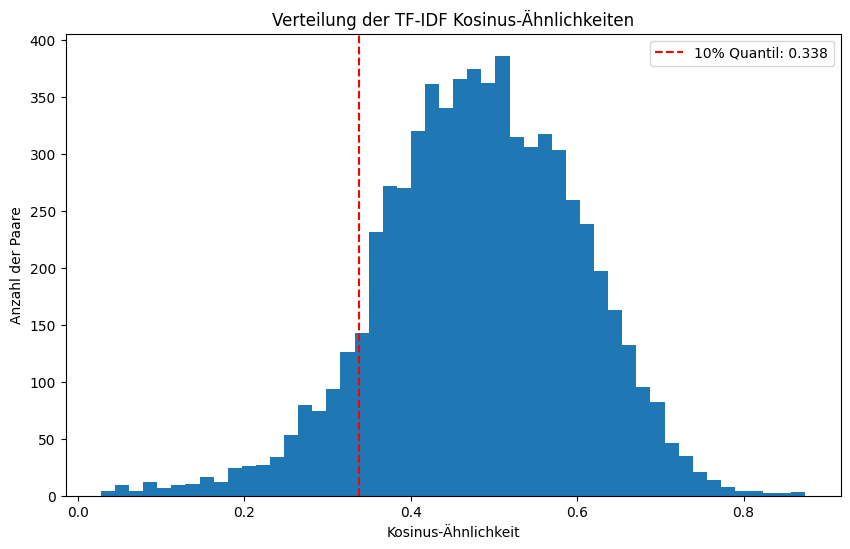

Schwellenwert für TF-IDF Ähnlichkeit: 0.338
TF-IDF Ähnlichkeitserkennung: 660 von 6592 Einträgen (10.01%) haben geringe Ähnlichkeit.
Überlappung mit regelbasierter Methode: 205 Einträge (31.06% der Einträge mit geringer Ähnlichkeit)

Beispiele für Einträge mit niedriger semantischer Ähnlichkeit:
ID: bgh_002-2019
Ähnlichkeit: 0.0274
Pressemitteilung (Anfang): Urteilsverkündung im Verfahren 1 StR 347/18


Ausgabejahr 2019
Erscheinungsdatum 09.01.2019


        Nr. 002/2019
      
Im Revisionsverfahren (1 StR 347/18) gegen das Urteil des Landgerichts Bochum ...
Urteil (Anfang): Tenor
Gemäß § 169 Abs. 3 Satz 1 GVG in der Fassung des Gesetzes zur Erweiterung der Medienöffentlichkeit in Gerichtsverfahren (EMöGG) vom 8. Oktober 2017 werden bei der Verkündung einer Entscheidung T...
--------------------------------------------------------------------------------
ID: bgh_041-2020
Ähnlichkeit: 0.0345
Pressemitteilung (Anfang): Verhandlungstermin am 14. Mai 2020, 9.00 Uhr  in Sachen VII ZR 174/19

In [6]:
### 2. Semantische Ähnlichkeit mit Embeddings

# Bei diesem Ansatz berechnen wir die semantische Ähnlichkeit zwischen Urteil und Pressemitteilung
# Pressemitteilungen mit niedriger Ähnlichkeit zum zugehörigen Urteil werden als potenziell irrelevant eingestuft

# Wir beginnen mit einem einfachen TF-IDF-basierten Ansatz
print("\n## Semantische Ähnlichkeit mit TF-IDF Embeddings")

# TF-IDF Vektorisierung für alle Texte
print("Berechne TF-IDF Vektoren...")

if USE_GPU:
    tfidf_vectorizer = cuTfidfVectorizer(
        max_features=10000,
        min_df=5,
        max_df=0.8,
        ngram_range=(1, 2),  # Uni- und Bi-gramme
        sublinear_tf=True
    )
else:
    tfidf_vectorizer = TfidfVectorizer(
        max_features=10000,
        min_df=5,
        max_df=0.8,
        ngram_range=(1, 2),  # Uni- und Bi-gramme
        sublinear_tf=True
    )

# Preprocessed Texte erstellen
print("Führe Text-Preprocessing durch...")
df['preprocessed_summary'] = df['summary'].fillna('').apply(preprocess_text)
df['preprocessed_judgement'] = df['judgement'].fillna('').apply(preprocess_text)

# Kombiniere alle Texte für das Training des Vektorisierers
all_texts = list(df['preprocessed_summary']) + list(df['preprocessed_judgement'])
tfidf_vectorizer.fit(all_texts)
print(f"Vokabulargröße: {len(tfidf_vectorizer.get_feature_names_out())}")

# Vektorisiere Urteile und Pressemitteilungen
summary_vectors = tfidf_vectorizer.transform(df['preprocessed_summary'])
judgement_vectors = tfidf_vectorizer.transform(df['preprocessed_judgement'])

# Berechne die Kosinus-Ähnlichkeit für jedes Paar
print("Berechne Kosinus-Ähnlichkeiten...")
similarities = []

# GPU-beschleunigte oder CPU-basierte Berechnung je nach Verfügbarkeit
if USE_GPU:
    for i in tqdm(range(len(df))):
        if i < summary_vectors.shape[0] and i < judgement_vectors.shape[0]:
            # Für GPU: normalisierte Vektoren und paarweise Ähnlichkeiten mit cuML
            summary_vec = cp.sparse.csr_matrix(summary_vectors[i])
            judgement_vec = cp.sparse.csr_matrix(judgement_vectors[i])
            
            # Umwandlung in dichte Arrays (notwendig für einige cuML-Operationen)
            summary_dense = summary_vec.toarray().astype(cp.float32)
            judgement_dense = judgement_vec.toarray().astype(cp.float32)
            
            # Normalisierung (für Kosinus-Ähnlichkeit)
            if cp.sum(summary_dense) > 0:
                summary_dense = normalize(summary_dense)
            if cp.sum(judgement_dense) > 0:
                judgement_dense = normalize(judgement_dense)
            
            # Kosinus-Ähnlichkeit = Skalarprodukt der normalisierten Vektoren
            similarity = cp.dot(summary_dense.flatten(), judgement_dense.flatten())
            similarities.append(float(similarity))
        else:
            similarities.append(0.0)
else:
    # Originale CPU-Implementierung
    for i in tqdm(range(len(df))):
        if i < summary_vectors.shape[0] and i < judgement_vectors.shape[0]:
            # Extrahiere die Vektoren für das aktuelle Paar
            summary_vec = summary_vectors[i]
            judgement_vec = judgement_vectors[i]
            
            # Berechne die Kosinus-Ähnlichkeit
            similarity = cosine_similarity(summary_vec, judgement_vec)[0][0]
            similarities.append(similarity)
        else:
            similarities.append(0.0)

# Speichere die Ähnlichkeiten im DataFrame
df['tfidf_similarity'] = similarities

# Analysiere die Ähnlichkeitsverteilung
plt.figure(figsize=(10, 6))
plt.hist(df['tfidf_similarity'], bins=50)
plt.title('Verteilung der TF-IDF Kosinus-Ähnlichkeiten')
plt.xlabel('Kosinus-Ähnlichkeit')
plt.ylabel('Anzahl der Paare')
plt.axvline(x=df['tfidf_similarity'].quantile(0.1), color='r', linestyle='--', 
            label=f'10% Quantil: {df["tfidf_similarity"].quantile(0.1):.3f}')
plt.legend()
plt.show()

# Definiere einen Schwellenwert für die Ähnlichkeit
# Wir nehmen an, dass die 10% der Paare mit der geringsten Ähnlichkeit 
# potenziell irrelevante Pressemitteilungen enthalten
similarity_threshold = df['tfidf_similarity'].quantile(0.1)
print(f"Schwellenwert für TF-IDF Ähnlichkeit: {similarity_threshold:.3f}")

# Identifiziere Paare mit niedriger Ähnlichkeit
df['is_dissimilar_tfidf'] = df['tfidf_similarity'] < similarity_threshold

# Auswertung der semantischen Ähnlichkeitsmethode
dissimilar_count = df['is_dissimilar_tfidf'].sum()
print(f"TF-IDF Ähnlichkeitserkennung: {dissimilar_count} von {len(df)} Einträgen ({dissimilar_count/len(df)*100:.2f}%) haben geringe Ähnlichkeit.")

# Vergleich mit regelbasierter Methode
overlap_count = (df['is_announcement_rule'] & df['is_dissimilar_tfidf']).sum()
print(f"Überlappung mit regelbasierter Methode: {overlap_count} Einträge ({overlap_count/dissimilar_count*100:.2f}% der Einträge mit geringer Ähnlichkeit)")

# Beispiele für Einträge mit niedriger Ähnlichkeit anzeigen
print("\nBeispiele für Einträge mit niedriger semantischer Ähnlichkeit:")
dissimilar_examples = df[df['is_dissimilar_tfidf']].sort_values('tfidf_similarity').head(3)
for _, row in dissimilar_examples.iterrows():
    print(f"ID: {row['id']}")
    print(f"Ähnlichkeit: {row['tfidf_similarity']:.4f}")
    print(f"Pressemitteilung (Anfang): {row['summary'][:200]}...")
    print(f"Urteil (Anfang): {row['judgement'][:200]}...")
    print("-" * 80)

## 4. Überwachtes Machine Learning

Der dritte Ansatz nutzt die Ergebnisse der vorherigen Methoden als "schwache Labels" für einen ML-Klassifikator:

- **Feature-Engineering**: TF-IDF Vektorisierung der Texte
- **Modell**: Logistische Regression mit Klassengewichtung
- **Evaluation**: Confusion Matrix und Klassifikationsreport
- **Feature-Analyse**: Wichtigste Wörter für beide Klassen

Das trainierte Modell lernt komplexere Muster als die regelbasierten Ansätze und kann diese auf neue Texte anwenden.


## Überwachtes Machine Learning (Klassifikation)
Erstelle Labels für das Trainieren basierend auf regelbasierter Methode...
Anzahl der als irrelevant markierten Einträge: 1815 (27.53%)
Erstelle Features für das Klassifikationsmodell...
Trainingsdaten: 5273 Einträge, Testdaten: 1319 Einträge
Klassen-Verteilung im Training: Counter({0: 3821, 1: 1452})
Trainiere Logistic Regression Klassifikator...

Confusion Matrix:
[[798 158]
 [ 76 287]]

Klassifikationsreport:
              precision    recall  f1-score   support

           0       0.91      0.83      0.87       956
           1       0.64      0.79      0.71       363

    accuracy                           0.82      1319
   macro avg       0.78      0.81      0.79      1319
weighted avg       0.84      0.82      0.83      1319


Wichtigste Merkmale für die Erkennung von irrelevanten Pressemitteilungen:
Features, die für 'irrelevant' sprechen:
  terminhinweis: 5.1233
  bundesverwaltungsgericht: 4.2673
  das bundesverwaltungsgericht:

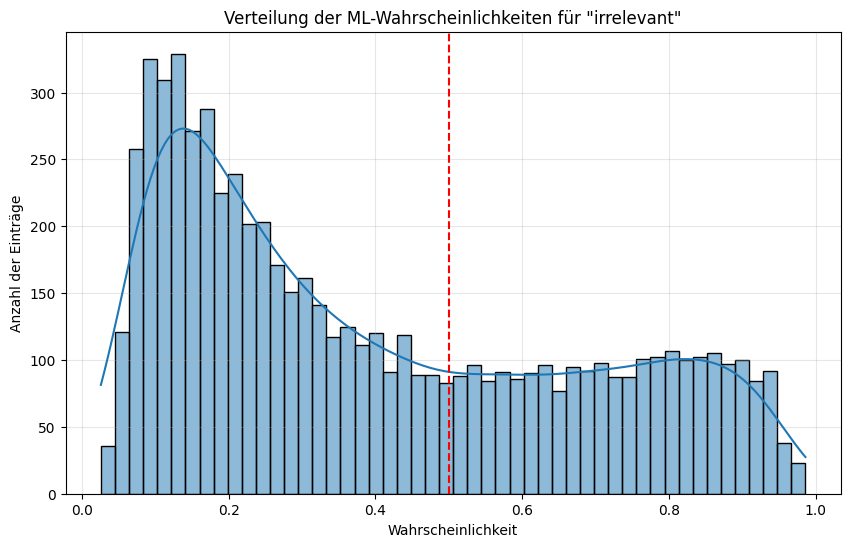


Beispiele für als irrelevant klassifizierte Einträge:
ID: bverwg_2007-36
Irrelevanz-Wahrscheinlichkeit: 0.9859
Regelbasiert: Ja, TF-IDF unähnlich: Nein
Pressemitteilung (Anfang): Pressemitteilung Nr. 36/2007  vom 12.06.2007


 EN


Antrag auf Einsicht in Sicherheitskonzept für Transrapid beim Bundesverwaltungsgericht erfolglos
 Das Bundesverwaltungsgericht in Leipzig hat den E...
--------------------------------------------------------------------------------
ID: bverwg_2007-31
Irrelevanz-Wahrscheinlichkeit: 0.9846
Regelbasiert: Ja, TF-IDF unähnlich: Nein
Pressemitteilung (Anfang): Pressemitteilung Nr. 31/2007  vom 16.05.2007


 EN


Versammlungsfreiheit für "Fuckparade 2001"
 Das Bundesverwaltungsgericht in Leipzig hat heute entschieden, dass der Polizeipräsident in Berlin die ...
--------------------------------------------------------------------------------
ID: bverwg_2012-5
Irrelevanz-Wahrscheinlichkeit: 0.9840
Regelbasiert: Ja, TF-IDF unähnlich: Ja
Pressemitteilung (Anfang): Pre

In [7]:
# In diesem Ansatz trainieren wir ein Modell, das auf Basis von Texteigenschaften 
# automatisch zwischen relevanten und irrelevanten Pressemitteilungen unterscheidet

print("\n## Überwachtes Machine Learning (Klassifikation)")

# Da wir keine manuell gelabelten Daten haben, nutzen wir die Ergebnisse
# der vorherigen Methoden als "schwache" Labels für das Training
print("Erstelle Labels für das Trainieren basierend auf regelbasierter Methode...")

# Wir betrachten Einträge als "irrelevant" (Label 1), wenn sie entweder
# durch die regelbasierte Methode als Ankündigungen erkannt wurden
# oder eine sehr niedrige semantische Ähnlichkeit aufweisen
df['is_irrelevant'] = ((df['is_announcement_rule']) | 
                       (df['tfidf_similarity'] < similarity_threshold * 0.8))

# Balancieren der Daten (optional)
irrelevant_count = df['is_irrelevant'].sum()
print(f"Anzahl der als irrelevant markierten Einträge: {irrelevant_count} ({irrelevant_count/len(df)*100:.2f}%)")

# Features für das Training erstellen (TF-IDF auf den Pressemitteilungen)
print("Erstelle Features für das Klassifikationsmodell...")
classifier_vectorizer = TfidfVectorizer(
    max_features=5000,
    min_df=3,
    max_df=0.85,
    ngram_range=(1, 2)
)

# Wir nutzen die Originaltexte (nicht die vorverarbeiteten)
# um auch strukturelle Merkmale zu erfassen
X = classifier_vectorizer.fit_transform(df['summary'].fillna(''))
y = df['is_irrelevant'].astype(int)

# Aufteilen in Trainings- und Testdaten
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Trainingsdaten: {X_train.shape[0]} Einträge, Testdaten: {X_test.shape[0]} Einträge")
print(f"Klassen-Verteilung im Training: {Counter(y_train)}")

# Logistische Regression für Klassifikation
print("Trainiere Logistic Regression Klassifikator...")

if USE_GPU:
    # GPU-beschleunigte Logistische Regression
    classifier = cuLogisticRegression(
        C=1.0,
        class_weight='balanced',
        max_iter=1000,
        random_state=42
    )
else:
    # CPU-basierte Logistische Regression
    classifier = LogisticRegression(
        C=1.0,
        class_weight='balanced',
        max_iter=1000,
        random_state=42
    )

classifier.fit(X_train, y_train)

# Modell evaluieren
y_pred = classifier.predict(X_test)
y_pred_prob = classifier.predict_proba(X_test)[:, 1]

# Zeige Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Klassifikationsreport zeigen
print("\nKlassifikationsreport:")
print(classification_report(y_test, y_pred))

# Die wichtigsten Merkmale für jede Klasse anzeigen
print("\nWichtigste Merkmale für die Erkennung von irrelevanten Pressemitteilungen:")
if hasattr(classifier, 'coef_'):
    feature_names = classifier_vectorizer.get_feature_names_out()
    # Sortiere nach absoluten Koeffizienten (größte zuerst)
    sorted_coef_indices = np.argsort(np.abs(classifier.coef_[0]))[::-1]
    
    # Top N positive und negative Features
    n_features = 20
    
    # Features, die für "irrelevant" sprechen (positive Koeffizienten)
    print("Features, die für 'irrelevant' sprechen:")
    pos_indices = [idx for idx in sorted_coef_indices if classifier.coef_[0][idx] > 0][:n_features]
    for idx in pos_indices:
        print(f"  {feature_names[idx]}: {classifier.coef_[0][idx]:.4f}")
    
    # Features, die für "relevant" sprechen (negative Koeffizienten)
    print("\nFeatures, die für 'relevant' sprechen:")
    neg_indices = [idx for idx in sorted_coef_indices if classifier.coef_[0][idx] < 0][:n_features]
    for idx in neg_indices:
        print(f"  {feature_names[idx]}: {classifier.coef_[0][idx]:.4f}")

# Anwenden des Modells auf den gesamten Datensatz
print("\nWende trainiertes Modell auf den gesamten Datensatz an...")
df['irrelevant_prob'] = classifier.predict_proba(X)[:, 1]
df['is_irrelevant_ml'] = classifier.predict(X)

# Auswertung der ML-Methode
ml_irrelevant_count = df['is_irrelevant_ml'].sum()
print(f"ML-Klassifikator: {ml_irrelevant_count} von {len(df)} Einträgen ({ml_irrelevant_count/len(df)*100:.2f}%) wurden als irrelevant klassifiziert.")

# Vergleich mit vorherigen Methoden
print("\nÜberlappung mit anderen Methoden:")
print(f"- Mit regelbasierter Methode: {(df['is_announcement_rule'] & df['is_irrelevant_ml']).sum()} Einträge")
print(f"- Mit TF-IDF Ähnlichkeit: {(df['is_dissimilar_tfidf'] & df['is_irrelevant_ml']).sum()} Einträge")

# Visualisierung der Wahrscheinlichkeiten
plt.figure(figsize=(10, 6))
sns.histplot(df['irrelevant_prob'], bins=50, kde=True)
plt.title('Verteilung der ML-Wahrscheinlichkeiten für "irrelevant"')
plt.xlabel('Wahrscheinlichkeit')
plt.ylabel('Anzahl der Einträge')
plt.axvline(x=0.5, color='red', linestyle='--')
plt.grid(True, alpha=0.3)
plt.show()

# Beispiele für als irrelevant klassifizierte Einträge anzeigen
print("\nBeispiele für als irrelevant klassifizierte Einträge:")
high_confidence_irrelevant = df[df['is_irrelevant_ml'] & (df['irrelevant_prob'] > 0.9)].sort_values('irrelevant_prob', ascending=False).head(3)
for _, row in high_confidence_irrelevant.iterrows():
    print(f"ID: {row['id']}")
    print(f"Irrelevanz-Wahrscheinlichkeit: {row['irrelevant_prob']:.4f}")
    print(f"Regelbasiert: {'Ja' if row['is_announcement_rule'] else 'Nein'}, TF-IDF unähnlich: {'Ja' if row['is_dissimilar_tfidf'] else 'Nein'}")
    print(f"Pressemitteilung (Anfang): {row['summary'][:200]}...")
    print("-" * 80)

## 5. Unüberwachtes Clustering

Der vierte Ansatz gruppiert die Pressemitteilungen basierend auf ihrer inhaltlichen Ähnlichkeit:

- **Dimensionsreduktion**: PCA für effizienteres Clustering
- **K-Means**: Clustering in verschiedene Themenbereiche
- **Cluster-Analyse**: Identifikation von Ankündigungs-Clustern
- **Validierung**: Vergleich mit anderen Methoden

Diese Methode hilft dabei, natürliche Gruppierungen in den Daten zu finden und potenzielle Ankündigungscluster zu identifizieren.


## Unüberwachte Verfahren (Clustering/Topic Modeling)
Verwende TF-IDF Vektoren für Clustering...
Reduziere Dimensionalität mit PCA und führe Clustering durch...
Erklärte Varianz durch PCA: 0.16
Reduziere auf 2 Dimensionen für Visualisierung...


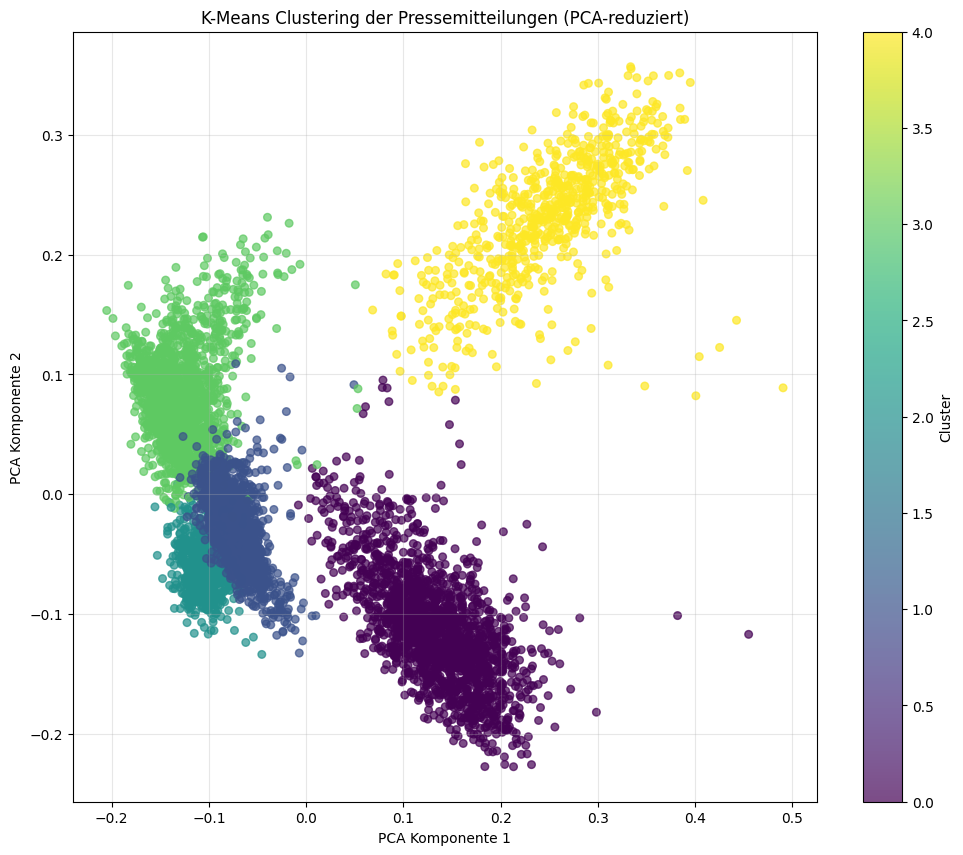


Analyse der Cluster im Vergleich zu regelbasierten Erkennungen:
Anteil der Ankündigungen in jedem Cluster (regelbasiert):
cluster
1    0.551427
3    0.335959
0    0.082707
4    0.046921
2    0.014398
Name: is_announcement_rule, dtype: float64

Cluster 1 hat den höchsten Anteil an potenziellen Ankündigungen (8.27%)

Wichtigste Wörter pro Cluster:
Cluster 0 (n=1862) - Top-Wörter: bundesgerichtshof, zivilsenat, pressestelle bundesgerichtshof, bundesgerichtshof telefon, pressestelle, telefon ergänzend, ergänzend dokument, erscheinungsdatum, ausgabejahr erscheinungsdatum, telefon
Cluster 1 (n=1507) - Top-Wörter: bundesverwaltungsgericht, kläger, bundesverwaltungsgericht entscheiden, pressemitteilung, vorinstanz, klägerin, vorinstanz urteil, klage, oberverwaltungsgericht, entscheiden

Beispiele aus dem erkannten 'Ankündigungs'-Cluster:
Beispiel 1:
ID: bag_24-20
Regelbasiert als Ankündigung erkannt: Nein
Pressemitteilung (Anfang): 28.07.2020
24/20 - Entgelttransparenzgesetz - Anspruch des Be

In [8]:
# In diesem Ansatz gruppieren wir die Pressemitteilungen anhand ihrer Ähnlichkeit,
# um Cluster zu identifizieren, die potenziell Ankündigungen oder irrelevante Inhalte enthalten

print("\n## Unüberwachte Verfahren (Clustering/Topic Modeling)")

# Wir nutzen die bereits berechneten TF-IDF Vektoren der Pressemitteilungen
print("Verwende TF-IDF Vektoren für Clustering...")

# Dimensionsreduktion mit PCA und K-Means Clustering
print("Reduziere Dimensionalität mit PCA und führe Clustering durch...")

if USE_GPU:
    # GPU-beschleunigte PCA
    pca = cuPCA(n_components=50, copy=True)
    summary_vectors_dense = summary_vectors.toarray().astype(cp.float32)
    summary_vectors_reduced = pca.fit_transform(summary_vectors_dense)
    
    # GPU-beschleunigtes K-Means
    n_clusters = 5  # Wir probieren 5 Cluster
    kmeans = cuKMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(summary_vectors_reduced)
else:
    # CPU-basierte PCA
    pca = PCA(n_components=50)  # Wir reduzieren auf 50 Dimensionen
    summary_vectors_dense = summary_vectors.toarray()
    summary_vectors_reduced = pca.fit_transform(summary_vectors_dense)
    
    # CPU-basiertes K-Means
    n_clusters = 5  # Wir probieren 5 Cluster
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(summary_vectors_reduced)

# Speichere die Cluster-Labels im DataFrame
df['cluster'] = cluster_labels

print(f"Erklärte Varianz durch PCA: {sum(pca.explained_variance_ratio_):.2f}")

# Visualisierung der Cluster (auf 2 Dimensionen reduziert für die Darstellung)
print("Reduziere auf 2 Dimensionen für Visualisierung...")
pca_vis = PCA(n_components=2)
summary_vectors_2d = pca_vis.fit_transform(summary_vectors_reduced)

# Plotte die Cluster
plt.figure(figsize=(12, 10))
scatter = plt.scatter(summary_vectors_2d[:, 0], summary_vectors_2d[:, 1], 
                      c=cluster_labels, cmap='viridis', alpha=0.7, s=30)
plt.colorbar(scatter, label='Cluster')
plt.title('K-Means Clustering der Pressemitteilungen (PCA-reduziert)')
plt.xlabel('PCA Komponente 1')
plt.ylabel('PCA Komponente 2')
plt.grid(True, alpha=0.3)
plt.show()

# Analysiere die Cluster: Welche Cluster enthalten mehr regelbasiert erkannte Ankündigungen?
print("\nAnalyse der Cluster im Vergleich zu regelbasierten Erkennungen:")
cluster_analysis = df.groupby('cluster')['is_announcement_rule'].mean().sort_values(ascending=False)
print("Anteil der Ankündigungen in jedem Cluster (regelbasiert):")
print(cluster_analysis)

# Bestimme den Cluster mit dem höchsten Anteil an Ankündigungen
announcement_cluster = cluster_analysis.index[0]
print(f"\nCluster {announcement_cluster} hat den höchsten Anteil an potenziellen Ankündigungen ({cluster_analysis[0]:.2%})")

# Extrahiere die wichtigsten Wörter für jeden Cluster
print("\nWichtigste Wörter pro Cluster:")
# Verwende den TF-IDF Vektorisierer, um die wichtigsten Wörter zu identifizieren
feature_names = tfidf_vectorizer.get_feature_names_out()

# Für jeden Cluster die Top-Wörter basierend auf den Cluster-Zentroiden bestimmen
for i in range(n_clusters):
    # Hole die Indizes der Dokumente in diesem Cluster
    cluster_docs = df[df['cluster'] == i].index
    
    if len(cluster_docs) > 0:
        # Berechne die durchschnittlichen TF-IDF-Werte für diesen Cluster
        cluster_tfidf = summary_vectors[cluster_docs].mean(axis=0)
        cluster_tfidf = np.asarray(cluster_tfidf).flatten()
        
        # Sortiere nach TF-IDF-Werten und hole die Top-Wörter
        top_indices = np.argsort(cluster_tfidf)[::-1][:20]
        top_words = [feature_names[idx] for idx in top_indices]
        
        # Zeige die Top-Wörter an
        print(f"Cluster {i} (n={len(cluster_docs)}) - Top-Wörter: {', '.join(top_words[:10])}")
        
        # Einige Beispiele aus dem Cluster anzeigen
        if i == announcement_cluster:
            print("\nBeispiele aus dem erkannten 'Ankündigungs'-Cluster:")
            cluster_examples = df[df['cluster'] == i].sample(min(3, len(df[df['cluster'] == i]))).reset_index(drop=True)
            for idx, row in cluster_examples.iterrows():
                print(f"Beispiel {idx+1}:")
                print(f"ID: {row['id']}")
                print(f"Regelbasiert als Ankündigung erkannt: {'Ja' if row['is_announcement_rule'] else 'Nein'}")
                print(f"Pressemitteilung (Anfang): {row['summary'][:200]}...")
                print("-" * 80)

# Vergleiche Cluster-basierte Erkennung mit anderen Methoden
# Wir betrachten den identifizierten Ankündigungs-Cluster als potenziell irrelevant
df['is_irrelevant_cluster'] = df['cluster'] == announcement_cluster

# Auswertung der Cluster-Methode
cluster_irrelevant_count = df['is_irrelevant_cluster'].sum()
print(f"\nCluster-Methode: {cluster_irrelevant_count} von {len(df)} Einträgen ({cluster_irrelevant_count/len(df)*100:.2f}%) im Ankündigungs-Cluster")

# Überlappung mit anderen Methoden
print("\nÜberlappung mit anderen Methoden:")
print(f"- Mit regelbasierter Methode: {(df['is_announcement_rule'] & df['is_irrelevant_cluster']).sum()} Einträge")
print(f"- Mit TF-IDF Ähnlichkeit: {(df['is_dissimilar_tfidf'] & df['is_irrelevant_cluster']).sum()} Einträge")
print(f"- Mit ML-Klassifikator: {(df['is_irrelevant_ml'] & df['is_irrelevant_cluster']).sum()} Einträge")

## 6. Vergleich und Kombination der Methoden

Im letzten Abschnitt vergleichen wir die Ergebnisse aller Methoden und kombinieren sie zu einem robusten Gesamtansatz:

- **Methodenvergleich**: Überlappung und Unterschiede
- **Ensemble-Ansatz**: Kombination durch Mehrheitsentscheidung
- **Grenzfälle**: Analyse von Beispielen mit unterschiedlichen Klassifikationen
- **Finaler Datensatz**: Bereinigung basierend auf kombiniertem Ansatz

Der finale bereinigte Datensatz enthält nur noch Pressemitteilungen, die von der Mehrheit der Methoden als relevant eingestuft wurden.

In [9]:
print("\n## Vergleich der verschiedenen Bereinigungsansätze")

# Erstelle einen Vergleich der verschiedenen Methoden
comparison_df = pd.DataFrame({
    'Methode': [
        '1. Regelbasiert (Keywords/Patterns)',
        '2. Semantische Ähnlichkeit (TF-IDF)',
        '3. ML-Klassifikation',
        '4. Clustering'
    ],
    'Anzahl irrelevanter Einträge': [
        df['is_announcement_rule'].sum(),
        df['is_dissimilar_tfidf'].sum(),
        df['is_irrelevant_ml'].sum(),
        df['is_irrelevant_cluster'].sum()
    ]
})

# Berechne den Prozentsatz
comparison_df['Prozent vom Datensatz'] = comparison_df['Anzahl irrelevanter Einträge'] / len(df) * 100

# Zeige Vergleichstabelle
print(comparison_df.to_string(index=False))

# Überlappung der Methoden visualisieren
plt.figure(figsize=(12, 10))

# Venn-Diagramm Daten vorbereiten
from matplotlib_venn import venn3, venn3_circles

# Erstelle Sets der irrelevanten Einträge für jede Methode
rule_based_set = set(df[df['is_announcement_rule']].index)
similarity_set = set(df[df['is_dissimilar_tfidf']].index)
ml_set = set(df[df['is_irrelevant_ml']].index)

# Venn-Diagramm zeichnen
venn = venn3(
    [rule_based_set, similarity_set, ml_set],
    ('Regelbasiert', 'Semantische Ähnlichkeit', 'ML-Klassifikation')
)
plt.title('Überlappung der erkannten irrelevanten Einträge')
plt.show()

# Kombinierter Ansatz: Einträge identifizieren, die von mindestens 2 Methoden als irrelevant eingestuft wurden
print("\n## Kombinierter Bereinigungsansatz")

# Zähle, von wie vielen Methoden ein Eintrag als irrelevant eingestuft wurde
df['irrelevant_votes'] = (
    df['is_announcement_rule'].astype(int) +
    df['is_dissimilar_tfidf'].astype(int) +
    df['is_irrelevant_ml'].astype(int) +
    df['is_irrelevant_cluster'].astype(int)
)

# Analysiere die Verteilung der Stimmen
vote_counts = df['irrelevant_votes'].value_counts().sort_index()
print("Verteilung der 'irrelevant'-Stimmen:")
for votes, count in vote_counts.items():
    print(f"{votes} Methode(n): {count} Einträge ({count/len(df)*100:.2f}%)")

# Wir betrachten Einträge als irrelevant, wenn mindestens 2 Methoden sie als irrelevant eingestuft haben
vote_threshold = 2
df['is_irrelevant_combined'] = df['irrelevant_votes'] >= vote_threshold

# Auswertung des kombinierten Ansatzes
combined_irrelevant_count = df['is_irrelevant_combined'].sum()
print(f"\nKombinierter Ansatz (≥{vote_threshold} Methoden): {combined_irrelevant_count} von {len(df)} Einträgen ({combined_irrelevant_count/len(df)*100:.2f}%) als irrelevant identifiziert.")

# Beispiele für Einträge, die von allen Methoden als irrelevant eingestuft wurden
full_agreement = df[df['irrelevant_votes'] == 4].head(3)
print("\nBeispiele für Einträge, die von ALLEN Methoden als irrelevant eingestuft wurden:")
for _, row in full_agreement.iterrows():
    print(f"ID: {row['id']}")
    print(f"Pressemitteilung (Anfang): {row['summary'][:200]}...")
    print("-" * 80)

# Beispiele für Grenzfälle (genau am Schwellenwert)
borderline_cases = df[df['irrelevant_votes'] == vote_threshold].head(3)
print(f"\nBeispiele für Grenzfälle (genau {vote_threshold} Methoden):")
for _, row in borderline_cases.iterrows():
    print(f"ID: {row['id']}")
    print(f"Regelbasiert: {'Ja' if row['is_announcement_rule'] else 'Nein'}, "
          f"TF-IDF unähnlich: {'Ja' if row['is_dissimilar_tfidf'] else 'Nein'}, "
          f"ML: {'Ja' if row['is_irrelevant_ml'] else 'Nein'}, "
          f"Cluster: {'Ja' if row['is_irrelevant_cluster'] else 'Nein'}")
    print(f"Pressemitteilung (Anfang): {row['summary'][:200]}...")
    print("-" * 80)

## Anwendung der kombinierten Methode auf den Datensatz

# Bereinigten Datensatz erstellen
cleaned_df = df[~df['is_irrelevant_combined']].copy()
print(f"\nBereinigter Datensatz: {len(cleaned_df)} Einträge (von ursprünglich {len(df)})")
print(f"Entfernt: {len(df) - len(cleaned_df)} Einträge ({(len(df) - len(cleaned_df))/len(df)*100:.2f}%)")

# Speichern des bereinigten Datensatzes
output_dir = Path('cleaned_data')
output_dir.mkdir(exist_ok=True)

# Speichere den bereinigten Datensatz
cleaned_output_file = output_dir / "cleaned_combined_methods.csv"
cleaned_df.to_csv(cleaned_output_file, index=False)
print(f"Bereinigter Datensatz gespeichert unter: {cleaned_output_file}")

# Speichere auch die Metadaten der Bereinigung
metadata_df = df[['id', 'is_announcement_rule', 'tfidf_similarity', 'is_dissimilar_tfidf', 
                 'is_irrelevant_ml', 'irrelevant_prob', 'cluster', 'is_irrelevant_cluster',
                 'irrelevant_votes', 'is_irrelevant_combined']]
metadata_output_file = output_dir / "cleaning_metadata.csv"
metadata_df.to_csv(metadata_output_file, index=False)
print(f"Bereinigungsmetadaten gespeichert unter: {metadata_output_file}")

print("\nBereinigungsprozess abgeschlossen!")


## Vergleich der verschiedenen Bereinigungsansätze
                            Methode  Anzahl irrelevanter Einträge  Prozent vom Datensatz
1. Regelbasiert (Keywords/Patterns)                          1625              24.651092
2. Semantische Ähnlichkeit (TF-IDF)                           660              10.012136
               3. ML-Klassifikation                          2246              34.071602
                      4. Clustering                          1507              22.861044


KeyError: "None of [Index([0, 0, 0, 0, 0, 0, 0, 0, 0, 0,\n       ...\n       1, 0, 1, 1, 1, 1, 1, 1, 1, 1],\n      dtype='int64', length=6592)] are in the [columns]"

<Figure size 1200x1000 with 0 Axes>